# Bay Wheels' Bicycle Sharing System Usage Analysis
## by Muhammad Elgendi

## Investigation Overview

This exploration and visualization study primarily focuses on understanding the usage pattern of the Bay Wheels' Bicycle Sharing System. This analysis of the bike usage pattern and user characteristics made in August 2020 shared data.

## Dataset Overview

This dataset was collected from trips in August 2020 and it has 152446 anonymized records.
Every record has the following variables and they can be catagorized into :

* Bike info : ride_id and rideable_type variables.
* Trip time : started_at and ended_at variables.
* Station info : start_station_name, start_station_id, end_station_id, end_station_name, start_lat, start_lng, end_lat and ent_lng.
* User info : member_casual variable.

Visualizations below are created from the cleaned data to facilitate the discovery of usage patterns and user characteristics.

In [2]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

%matplotlib inline

# suppress warnings from final output
import warnings
warnings.simplefilter("ignore")

In [3]:
# load in the dataset into a pandas dataframe and do preprocessing

# read in the dataset
aug20 = pd.read_csv('202008-baywheels-tripdata.csv')

# remove unuseful colums
aug20.drop(['start_lat','start_lng','end_lat','end_lng'],axis=1,inplace=True)

# convert features to the correct type
# convert rideable_type to catagory variable
aug20['rideable_type'] = aug20['rideable_type'].astype('category')
# convert started_at to datetime variable
aug20['started_at'] = pd.to_datetime(aug20['started_at'])
# convert ended_at to datetime variable
aug20['ended_at'] = pd.to_datetime(aug20['ended_at'])
# convert start_station_id to string variable 
aug20['start_station_id'] = aug20['start_station_id'].astype('str')
# convert end_station_id to string variable
aug20['end_station_id'] = aug20['end_station_id'].astype('str')

# feature engineering
# add new variables for trip duration, start_date, start_hour, and start_day to the dataset

# calculate difference between timestamps in seconds
aug20['duration_sec'] = (aug20['ended_at'] - aug20['started_at']).dt.total_seconds()

# calculate difference between timestamps in minutes
aug20['duration_min'] = aug20['duration_sec'] / 60

# add date in format year - month - day 
aug20['start_date'] = aug20['started_at'].dt.strftime('%Y-%m-%d')

# add hour of the day
aug20['start_hour'] = aug20['started_at'].dt.strftime('%H')

# add weekday
aug20['start_day'] = aug20['started_at'].dt.strftime('%A')

# remove trips that have duration < 0 
aug20.drop(aug20[aug20['duration_sec'] < 0].index,axis=0,inplace=True)

# issue: convert start_hour to int
aug20['start_hour'] = aug20['start_hour'].astype('int')

# issue : convert start_day to ordinal category
days = ['Saturday','Sunday','Monday','Tuesday','Wednesday','Thursday','Friday']
weekday_type = pd.api.types.CategoricalDtype(days,True)
aug20['start_day'] = aug20['start_day'].astype(weekday_type)

## User Types and Their Daily Usage

>Casual users contributed the majority of the bike usage in August 2020, about 59%, while about 41% were consumed by members. Both casual users and members ride the most during Saturday. Casual users use Bay Wheels the most on weekends, whereas members have roughly equal usage through the week with peaks on Saturdays and Mondays.

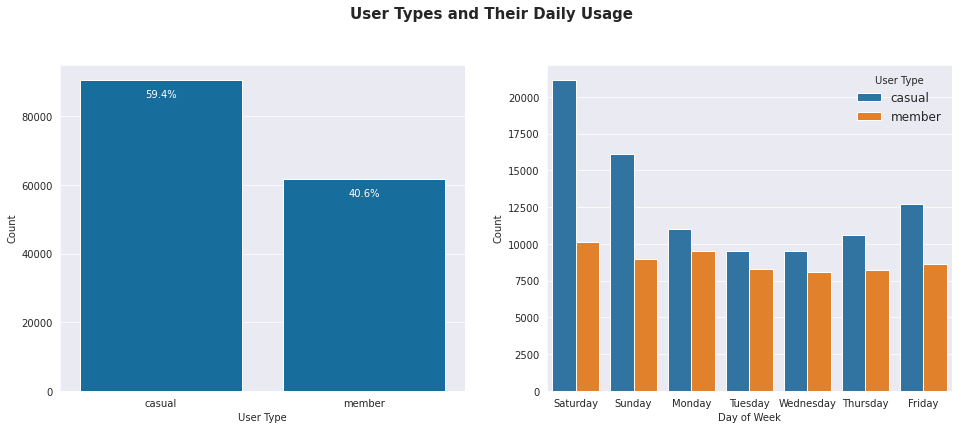

In [29]:
sb.set_style('darkgrid')

# How much of the users are customers ?
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
sb.countplot(data = aug20,x = 'member_casual',color=sb.color_palette('colorblind')[0])
# add annotations
n_points = aug20.shape[0]
user_counts = aug20['member_casual'].value_counts()
# get the current tick locations and labels
locs, labels = plt.xticks() 
# loop through each pair of locations and labels
for loc, label in zip(locs, labels):
  # get the text property for the label to get the correct count
  count = user_counts[label.get_text()]
  pct_string = '{:0.1f}%'.format(100*count/n_points)
  # print the annotation just below the top of the bar
  plt.text(loc, count-5000, pct_string, ha = 'center', color = 'w')
plt.xlabel('User Type')
plt.ylabel('Count');

# users usage over the week
plt.subplot(1,2,2)
sb.countplot(data=aug20, x='start_day', hue='member_casual');
plt.xlabel('Day of Week')
plt.ylabel('Count')
plt.legend(title="User Type",fontsize='large',frameon=False);
plt.suptitle('User Types and Their Daily Usage', fontsize=15, fontweight='semibold', y=1.015);

## Average Daily Trip Durations for Casual Users and Members  

> Casual users who used Bay Wheels on Sunday and Monday have longer trips on average than all other casual users, with trips being shorter in the middle of the week (namely: Monday, Tuesday, and Wednesday), whereas members who used Bay Wheels on Tuesday have longer trips on average than all other members.

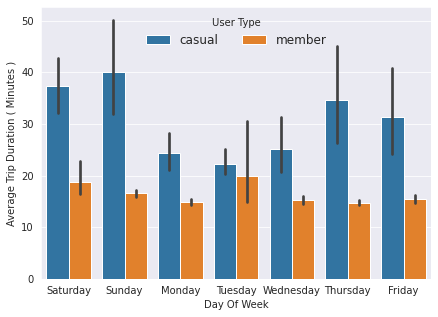

In [37]:
# trip duration variation in the week between customers and subscribers
sb.set_style('darkgrid')

plt.figure(figsize=(7,5))
ax = sb.barplot(data = aug20, x = 'start_day', y = 'duration_min', hue = 'member_casual')
ax.legend(loc = 0, ncol = 2,fontsize='large',frameon=False, title = 'User Type');
plt.xlabel('Day Of Week')
plt.ylabel('Average Trip Duration ( Minutes )');

## Hourly Usage During The Week for Casual Users and Members

> The pattern of usage is different between casual users and members.
For members there exist a consistent usage over the whole week, their intense usage on Saturday is between 11 AM and 6 PM and on Sunday their usage is focused between 12 PM and 4 PM and for all other weekdays, the focused usage is between 5 PM and 6 PM.

> For casual users, their usage is intense on Saturday, Sunday, and Friday and light in the rest of the days. as members, their usage on Saturday is between 11 AM and 6 PM But on Sunday their usage is focused between 1 PM and 5 PM, and for Friday there is an intense usage between 5 PM and 6 PM.

> Most of the usage was observed between 5 PM and 6 PM for all users.

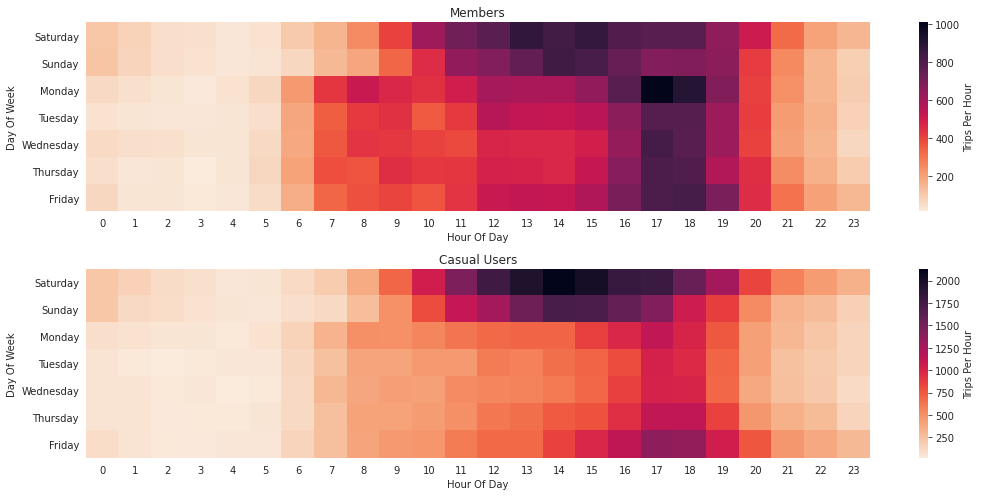

In [42]:
# hourly usage during the week for customers and subscribers
plt.figure(figsize=(15,7))

# subscribers plot
plt.subplot(2, 1, 1)
subscriber_counts = aug20.query('member_casual == "member"').groupby(['start_day','start_hour']).size()
subscriber_counts = subscriber_counts.reset_index(name='count')
subscriber_counts = subscriber_counts.pivot(index='start_day',columns='start_hour',values='count')
# plot heatmap
sb.heatmap(subscriber_counts, cmap='rocket_r',cbar_kws = {'label' : 'Trips Per Hour'});
plt.xlabel('Hour Of Day')
plt.ylabel('Day Of Week')
plt.title('Members', loc='center');
plt.tight_layout();

# customers plot
plt.subplot(2, 1, 2)
customer_counts = aug20.query('member_casual == "casual"').groupby(['start_day','start_hour']).size()
customer_counts = customer_counts.reset_index(name='count')
customer_counts = customer_counts.pivot(index='start_day',columns='start_hour',values='count')
# plot heatmap
sb.heatmap(customer_counts, cmap='rocket_r',cbar_kws = {'label' : 'Trips Per Hour'});
plt.xlabel('Hour Of Day')
plt.ylabel('Day Of Week')
plt.title('Casual Users', loc='center');
plt.tight_layout();

## Summary
There were more casual users using the bike-sharing system than members overall, both of which ride the most during Saturdays. Different usage patterns and riding habits are observed between the two types of users. Casual users used the system heavily on weekends, whereas members used it intensively on Tuesday. Most of the usage was observed between 5 PM and 6 PM for all users.